In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:95% !important; }</style>"))
# curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/C_0.0_O_0.0_CO_0.45.tar.gz

In [2]:
import prodimopy.read as pread
import prodimopy.plot as pplot
import ipympl
# from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.constants import h as planck_h
from scipy.constants import k as boltzmann_k
from scipy.constants import c as speed_of_light
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
%matplotlib widget

In [3]:
def flux_prodimo(model, specie, wlrange):
    wl, flux_nu = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='W')
    wl *= 1e-6
    flux_lambda = (speed_of_light / wl ** 2) * (flux_nu)
    total_flux = simpson(flux_lambda, wl)
    return total_flux

def convolve(wl, flux, specR, sample=1):
    print("INFO: convolve FLiTs spectrum ... ")

    from astropy.convolution import convolve_fft
    from astropy.convolution import Gaussian1DKernel

    # Make a new wl grid
    wl_log = np.logspace(np.log10(np.nanmin(wl)), np.log10(np.nanmax(wl)), num=np.size(wl) * sample)

    # Find stddev of Gaussian kernel for smoothing
    # taken from here https://github.com/spacetelescope/pysynphot/issues/78
    R_grid = (wl_log[1:-1] + wl_log[0:-2]) / (wl_log[1:-1] - wl_log[0:-2]) / 2
    sigma = np.median(R_grid) / specR
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(wl_log, wl, flux)

    # in the idl script this is interpreted as the FWHM,
    # but the convolution routine wants stddev use relation
    # FWHM=2*sqrt(2ln2)*stddev=2.355/stddev
    # this should than be consistent with the result from the
    # ProDiMo idl script
    gauss = Gaussian1DKernel(stddev=sigma / 2.355)
    flux_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    flux_sm = np.interp(wl, wl_log, flux_conv)

    cut = 2 * int(sigma)
    flux_smc = flux_sm[cut:(len(flux_sm) - cut)]
    wlc = wl[cut:(len(wl) - cut)]

    return wlc, flux_smc

def plot_density(model):
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)
    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0])
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1])
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_temp(model):
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)
    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[0], fig=fig)
    tcont = pplot.Contour(model.td, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[1], fig=fig)
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_abundance(model, specie, includeIce=False):
    pp = pplot.Plot(None)
    if includeIce:
        fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[0])
        fig = pp.plot_abuncont(model, specie + "#", zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[1])
        axs[1].set_ylabel("")
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axs[0].text(0.05, 0.95, specie, transform=axs[0].transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

        axs[1].text(0.95, 0.95, specie + "#", transform=axs[1].transAxes, fontsize=14,
                    verticalalignment='top', horizontalalignment="right", bbox=props)
    else:
        fig, ax = plt.subplots(figsize=(5, 2.7))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=ax)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, specie, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()

In [4]:
model_path = './models/C_0.0_O_0.0_CO_0.45'
model = pread.read_prodimo(model_path)

READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/SED.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/image.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/specFLiTs.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45/Parameter.out  ...
INFO: Reading time:  17.78 s
 


### Disk Information

PLOT: plot_cont ...
PLOT: plot_cont ...


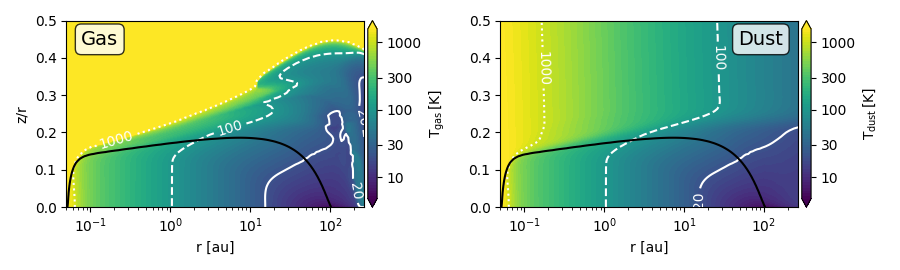

PLOT: plot_cont ...
PLOT: plot_cont ...


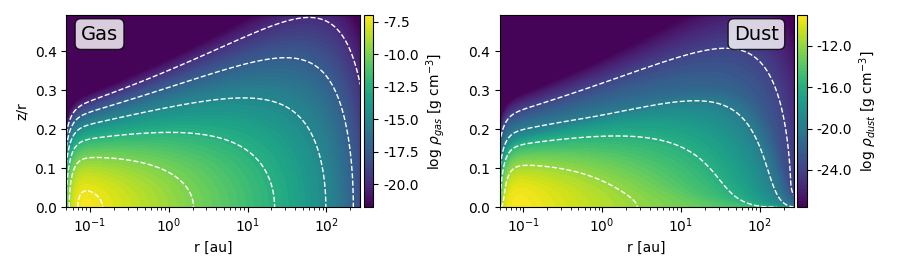

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


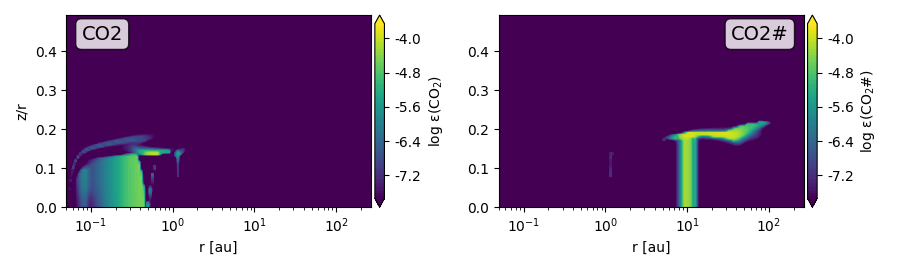

In [15]:
plt.close('all')
plot_temp(model)
plot_density(model)
plot_abundance(model, specie="CO2", includeIce=True)

### Spectrum Information

In [6]:
wlrange = [13, 16]

In [7]:
species = [est.ident for est in model.lineEstimates]
species = sorted(list(set(species)))
species_with_lines = list()
species_strong_lines = list()
for specie in species:
    molecule_spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True)
    if np.sum(molecule_spec[1]) > 0:
        species_with_lines.append(specie)
        species_strong_lines.append(
            sorted([line for line in model.selectLineEstimates(ident=specie, wlrange=wlrange) if line.flux > 1e-20],
                   key=lambda x: x.flux, reverse=True))
clear_output()

In [8]:
print(species_with_lines)

['C2H2_H', 'CO2_H', 'HCN_H', 'NH3_H', 'Ne++', 'OH', 'o-H2', 'o-H2O', 'p-H2', 'p-H2O']


INFO: convolve FLiTs spectrum ... 
INFO: convolve FLiTs spectrum ... 


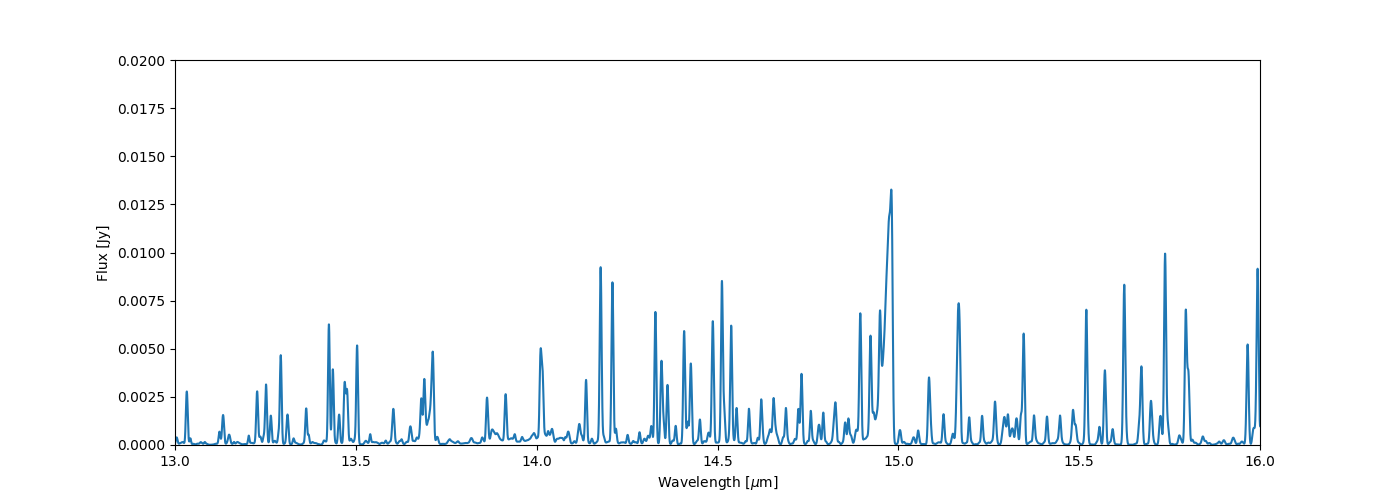

INFO: gen_specFromLineEstimates: build spectrum for 19393 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  1.29 s
C2H2_H 0.4408692582216496
INFO: gen_specFromLineEstimates: build spectrum for 5115 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  0.43 s
CO2_H 1.087712578416212
INFO: gen_specFromLineEstimates: build spectrum for 2107 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  0.33 s
HCN_H 1.5227708061115912
INFO: gen_specFromLineEstimates: build spectrum for 1194 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  0.29 s
NH3_H 0.9363971624545832
INFO: gen_specFromLineEstimates: build spectrum for 1 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  0.25 s
Ne++ 0.06598600913066792
INFO: gen_specFromLineEstimates: build spectrum for 47 lines ...
INFO: gen_specFromLineEstimates: convolve spectrum ...
INFO: time:  0.24 s
OH 0.11538444034485554
INFO

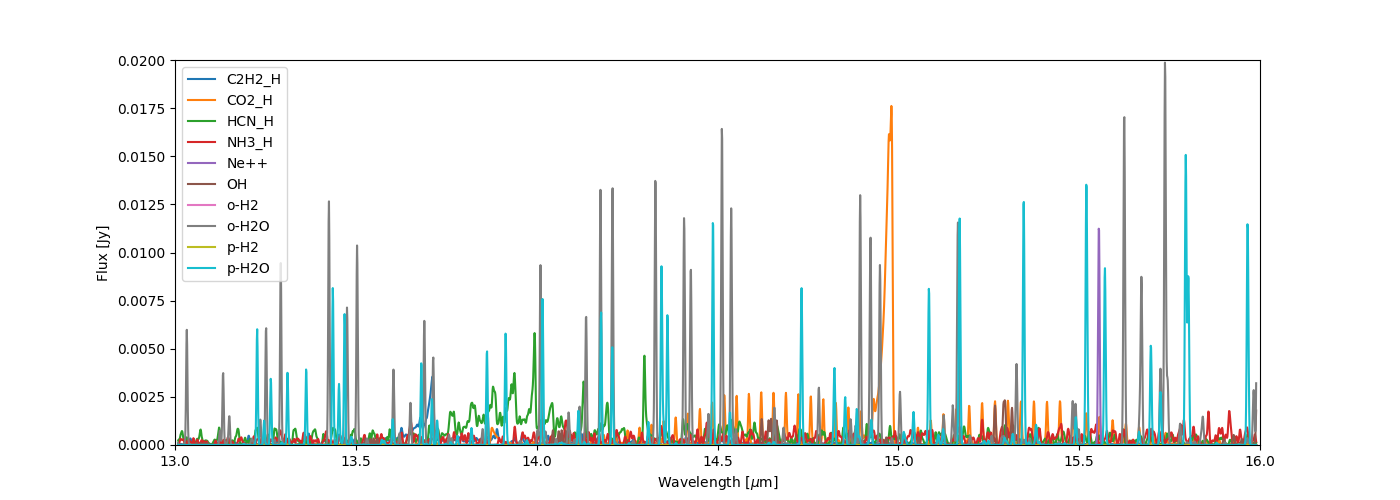

In [16]:
plt.close('all')
fig,ax = plt.subplots(figsize=(14,5))
_, flux = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux, 3000)
wl, flux_cont = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux_cont, 3000)
flux -= flux_cont
ax.plot(wl, flux)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
plt.show()
total_spec = None
fig,ax = plt.subplots(figsize=(14,5))
for specie in species_with_lines:
    spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='Jy')
    print(specie, np.sum(spec[1]))
    if np.sum(spec[1]) > 1e-30:
        ax.plot(spec[0], spec[1], label=specie)
    if total_spec is None:
        total_spec = spec[1]
    else:
        total_spec += spec[1]
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
ax.legend(loc='best')
plt.show()

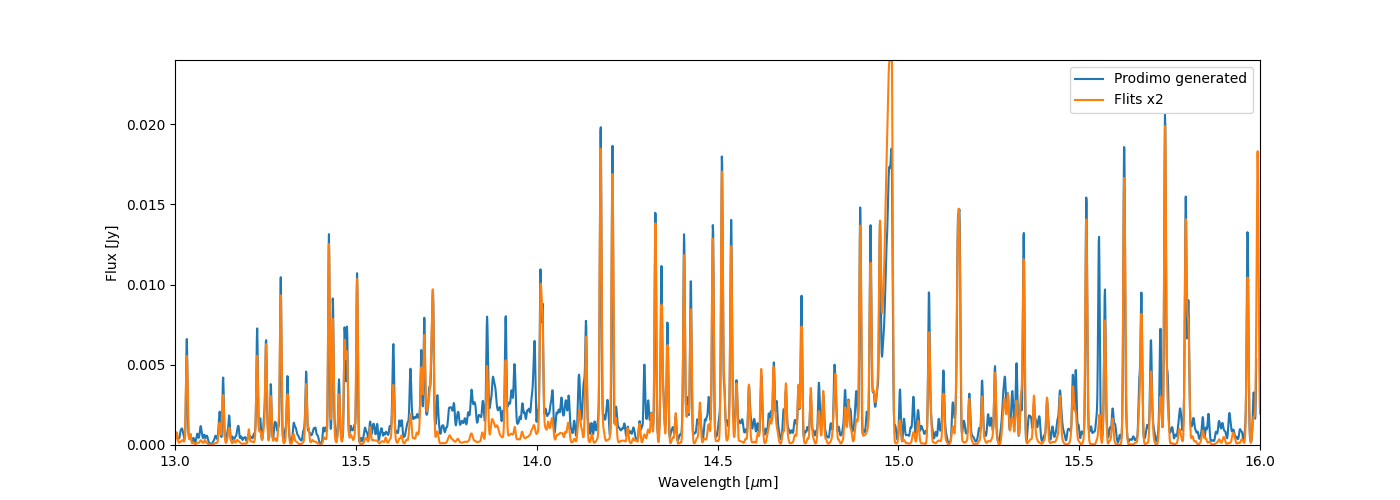

In [17]:
plt.close('all')
fig,ax = plt.subplots(figsize=(14,5))
ax.plot(spec[0], total_spec, label='Prodimo generated')
ax.plot(wl, 2*flux, label='Flits x2')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.024)
ax.legend()
plt.show()

PLOT: plot_cont ...


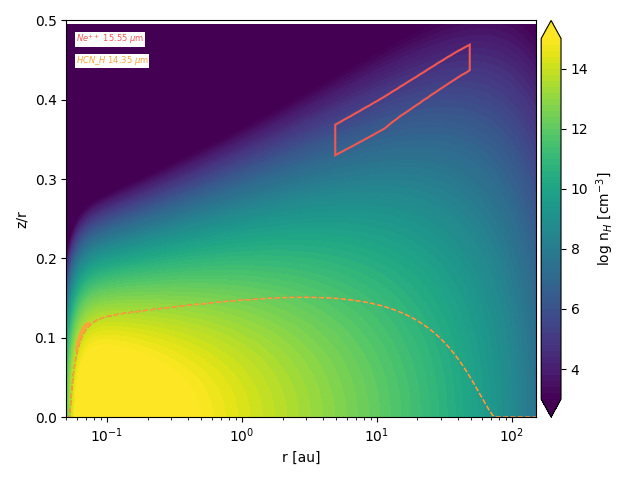

In [18]:
plt.close('all')
pp=pplot.Plot(None)
fig=pp.plot_line_origin(model,[["Ne++",15.6],["HCN_H",14.35]],field=model.nHtot,
                        label=r"log n$_{H}$ [cm$^{-3}$]",zlim=[1e3,1e15],extend="both",cb_format="%.0f",zr=True,xlog=True,
                        xlim=[None,150],ylim=[None,0.5],
                        showContOrigin=False,showRadialLines=False) # this adds an additional contour
plt.tight_layout()
plt.show()

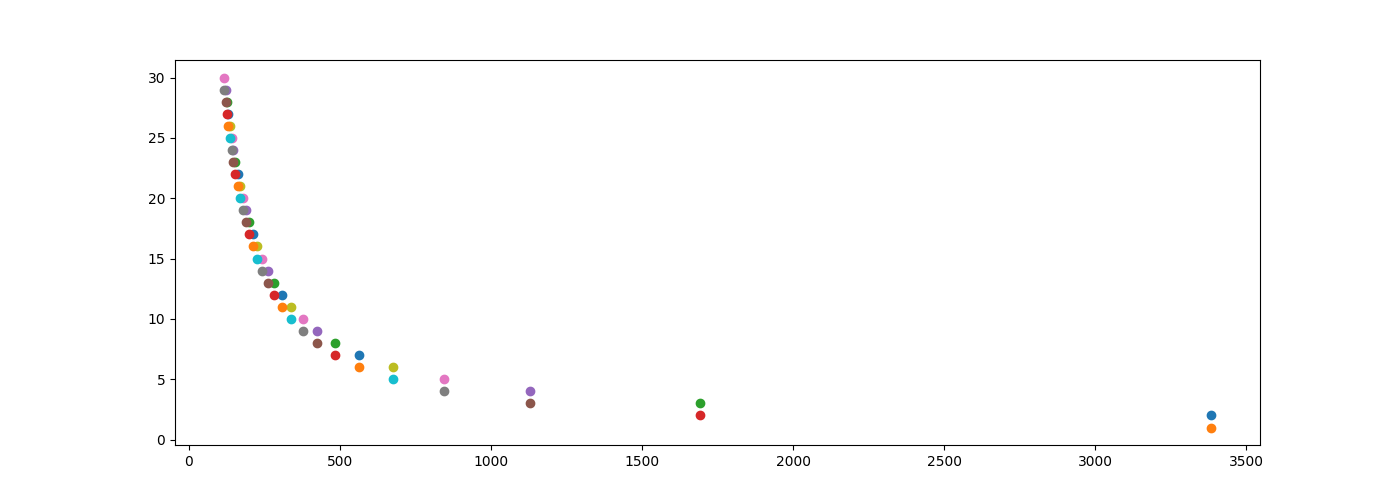

In [19]:
plt.close('all')
line_estimates = model.selectLineEstimates('HCN')
fig,ax = plt.subplots(figsize=(14,5))
for line in line_estimates:
    ax.scatter(line.wl, line.jup)
    ax.scatter(line.wl, line.jlow)
plt.show()

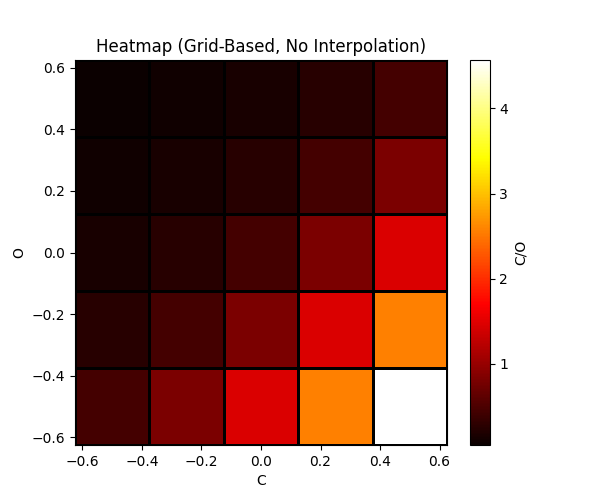

In [22]:
plt.close('all')
x = np.array([-0.5, -0.25, 0, 0.25, 0.5])
y = np.array([-0.5, -0.25, 0, 0.25, 0.5])
temp = np.array([[0.45, 0.813, 1.445, 2.57, 4.57], 
                 [0.257, 0.45, 0.813, 1.445, 2.57], 
                 [0.145, 0.257, 0.45, 0.813, 1.445], 
                 [0.0813, 0.145, 0.257, 0.45, 0.813], 
                 [0.045, 0.0813, 0.145, 0.257, 0.45]])  # 5x5 grid of temperatures

X, Y = np.meshgrid(x, y)  # Create a grid

plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, temp, cmap='hot', edgecolors='black', linewidth=1)
plt.colorbar(label="C/O")
plt.xlabel("C")
plt.ylabel("O")
plt.title("Heatmap (Grid-Based, No Interpolation)")
plt.show()